
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [1]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/


In [2]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d snap/amazon-fine-food-reviews

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
 ! unzip amazon-fine-food-reviews

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [6]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [ ]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [7]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [8]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows. 
reviews = reviews[reviews['Score']!=3][['Text', 'Score']].dropna()
reviews['Score'] = np.where(reviews.Score>3, 1, 0)


<font size=4>Grader function 2 </font>

In [ ]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [9]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [10]:
#remove HTML from the Text column and save in the Text column only
import re
reviews['Text'] = reviews['Text'].apply(lambda x : re.sub('<.*?>','',x))

In [ ]:
#print head 5
reviews.head()

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [11]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 
from sklearn.model_selection import train_test_split
X = reviews.drop(['Score'], axis=1)
y = reviews['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=33)

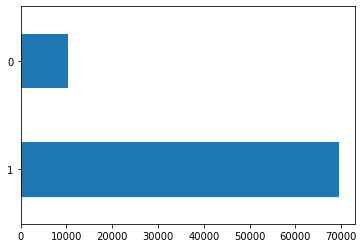

In [ ]:
y_train.value_counts().plot(kind='barh')

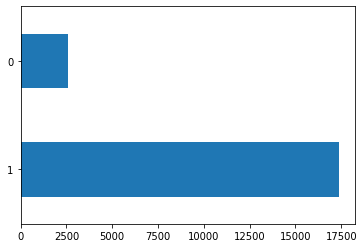

In [ ]:
y_test.value_counts().plot(kind='barh')

In [ ]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [12]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [ ]:
sequence_output.shape

TensorShape([None, None, 768])

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [13]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
vocab_file

b'/tmp/tfhub_modules/03d6fb3ce1605ad9e5e9ed5346b2fb9623ef4d3d/assets/vocab.txt'

In [14]:
#import tokenization - We have given tokenization.py file
"""Tokenization classes."""
#This code snippet has been copied from github

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import re
import unicodedata
import six
import tensorflow as tf


def validate_case_matches_checkpoint(do_lower_case, init_checkpoint):
  """Checks whether the casing config is consistent with the checkpoint name."""

  # The casing has to be passed in by the user and there is no explicit check
  # as to whether it matches the checkpoint. The casing information probably
  # should have been stored in the bert_config.json file, but it's not, so
  # we have to heuristically detect it to validate.

  if not init_checkpoint:
    return

  m = re.match("^.*?([A-Za-z0-9_-]+)/bert_model.ckpt", init_checkpoint)
  if m is None:
    return

  model_name = m.group(1)

  lower_models = [
      "uncased_L-24_H-1024_A-16", "uncased_L-12_H-768_A-12",
      "multilingual_L-12_H-768_A-12", "chinese_L-12_H-768_A-12"
  ]

  cased_models = [
      "cased_L-12_H-768_A-12", "cased_L-24_H-1024_A-16",
      "multi_cased_L-12_H-768_A-12"
  ]

  is_bad_config = False
  if model_name in lower_models and not do_lower_case:
    is_bad_config = True
    actual_flag = "False"
    case_name = "lowercased"
    opposite_flag = "True"

  if model_name in cased_models and do_lower_case:
    is_bad_config = True
    actual_flag = "True"
    case_name = "cased"
    opposite_flag = "False"

  if is_bad_config:
    raise ValueError(
        "You passed in `--do_lower_case=%s` with `--init_checkpoint=%s`. "
        "However, `%s` seems to be a %s model, so you "
        "should pass in `--do_lower_case=%s` so that the fine-tuning matches "
        "how the model was pre-training. If this error is wrong, please "
        "just comment out this check." % (actual_flag, init_checkpoint,
                                          model_name, case_name, opposite_flag))


def convert_to_unicode(text):
  """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text.decode("utf-8", "ignore")
    elif isinstance(text, unicode):
      return text
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")


def printable_text(text):
  """Returns text encoded in a way suitable for print or `tf.logging`."""

  # These functions want `str` for both Python2 and Python3, but in one case
  # it's a Unicode string and in the other it's a byte string.
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text
    elif isinstance(text, unicode):
      return text.encode("utf-8")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")


def load_vocab(vocab_file):
  """Loads a vocabulary file into a dictionary."""
  vocab = collections.OrderedDict()
  index = 0
  with tf.io.gfile.GFile(vocab_file, "r") as reader:
    while True:
      token = convert_to_unicode(reader.readline())
      if not token:
        break
      token = token.strip()
      vocab[token] = index
      index += 1
  return vocab


def convert_by_vocab(vocab, items):
  """Converts a sequence of [tokens|ids] using the vocab."""
  output = []
  for item in items:
    output.append(vocab[item])
  return output


def convert_tokens_to_ids(vocab, tokens):
  return convert_by_vocab(vocab, tokens)


def convert_ids_to_tokens(inv_vocab, ids):
  return convert_by_vocab(inv_vocab, ids)


def whitespace_tokenize(text):
  """Runs basic whitespace cleaning and splitting on a piece of text."""
  text = text.strip()
  if not text:
    return []
  tokens = text.split()
  return tokens


class FullTokenizer(object):
  """Runs end-to-end tokenziation."""

  def __init__(self, vocab_file, do_lower_case=True):
    self.vocab = load_vocab(vocab_file)
    self.inv_vocab = {v: k for k, v in self.vocab.items()}
    self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
    self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

  def tokenize(self, text):
    split_tokens = []
    for token in self.basic_tokenizer.tokenize(text):
      for sub_token in self.wordpiece_tokenizer.tokenize(token):
        split_tokens.append(sub_token)

    return split_tokens

  def convert_tokens_to_ids(self, tokens):
    return convert_by_vocab(self.vocab, tokens)

  def convert_ids_to_tokens(self, ids):
    return convert_by_vocab(self.inv_vocab, ids)


class BasicTokenizer(object):
  """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

  def __init__(self, do_lower_case=True):
    """Constructs a BasicTokenizer.
    Args:
      do_lower_case: Whether to lower case the input.
    """
    self.do_lower_case = do_lower_case

  def tokenize(self, text):
    """Tokenizes a piece of text."""
    text = convert_to_unicode(text)
    text = self._clean_text(text)


    # This was added on November 1st, 2018 for the multilingual and Chinese
    # models. This is also applied to the English models now, but it doesn't
    # matter since the English models were not trained on any Chinese data
    # and generally don't have any Chinese data in them (there are Chinese
    # characters in the vocabulary because Wikipedia does have some Chinese
    # words in the English Wikipedia.).
    text = self._tokenize_chinese_chars(text)

    orig_tokens = whitespace_tokenize(text)
    split_tokens = []
    for token in orig_tokens:
      if self.do_lower_case:
        token = token.lower()
        token = self._run_strip_accents(token)
      split_tokens.extend(self._run_split_on_punc(token))

    output_tokens = whitespace_tokenize(" ".join(split_tokens))
    return output_tokens

  def _run_strip_accents(self, text):
    """Strips accents from a piece of text."""
    text = unicodedata.normalize("NFD", text)
    output = []
    for char in text:
      cat = unicodedata.category(char)
      if cat == "Mn":
        continue
      output.append(char)
    return "".join(output)

  def _run_split_on_punc(self, text):
    """Splits punctuation on a piece of text."""
    chars = list(text)
    i = 0
    start_new_word = True
    output = []
    while i < len(chars):
      char = chars[i]
      if _is_punctuation(char):
        output.append([char])
        start_new_word = True
      else:
        if start_new_word:
          output.append([])
        start_new_word = False
        output[-1].append(char)
      i += 1

    return ["".join(x) for x in output]

  def _tokenize_chinese_chars(self, text):
    """Adds whitespace around any CJK character."""
    output = []
    for char in text:
      cp = ord(char)
      if self._is_chinese_char(cp):
        output.append(" ")
        output.append(char)
        output.append(" ")
      else:
        output.append(char)
    return "".join(output)

  def _is_chinese_char(self, cp):
    """Checks whether CP is the codepoint of a CJK character."""
    # This defines a "chinese character" as anything in the CJK Unicode block:
    #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
    #
    # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
    # despite its name. The modern Korean Hangul alphabet is a different block,
    # as is Japanese Hiragana and Katakana. Those alphabets are used to write
    # space-separated words, so they are not treated specially and handled
    # like the all of the other languages.
    if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
        (cp >= 0x3400 and cp <= 0x4DBF) or  #
        (cp >= 0x20000 and cp <= 0x2A6DF) or  #
        (cp >= 0x2A700 and cp <= 0x2B73F) or  #
        (cp >= 0x2B740 and cp <= 0x2B81F) or  #
        (cp >= 0x2B820 and cp <= 0x2CEAF) or
        (cp >= 0xF900 and cp <= 0xFAFF) or  #
        (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
      return True

    return False

  def _clean_text(self, text):
    """Performs invalid character removal and whitespace cleanup on text."""
    output = []
    for char in text:
      cp = ord(char)
      if cp == 0 or cp == 0xfffd or _is_control(char):
        continue
      if _is_whitespace(char):
        output.append(" ")
      else:
        output.append(char)
    return "".join(output)


class WordpieceTokenizer(object):
  """Runs WordPiece tokenziation."""

  def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=200):
    self.vocab = vocab
    self.unk_token = unk_token
    self.max_input_chars_per_word = max_input_chars_per_word

  def tokenize(self, text):
    """Tokenizes a piece of text into its word pieces.
    This uses a greedy longest-match-first algorithm to perform tokenization
    using the given vocabulary.
    For example:
      input = "unaffable"
      output = ["un", "##aff", "##able"]
    Args:
      text: A single token or whitespace separated tokens. This should have
        already been passed through `BasicTokenizer.
    Returns:
      A list of wordpiece tokens.
    """

    text = convert_to_unicode(text)

    output_tokens = []
    for token in whitespace_tokenize(text):
      chars = list(token)
      if len(chars) > self.max_input_chars_per_word:
        output_tokens.append(self.unk_token)
        continue

      is_bad = False
      start = 0
      sub_tokens = []
      while start < len(chars):
        end = len(chars)
        cur_substr = None
        while start < end:
          substr = "".join(chars[start:end])
          if start > 0:
            substr = "##" + substr
          if substr in self.vocab:
            cur_substr = substr
            break
          end -= 1
        if cur_substr is None:
          is_bad = True
          break
        sub_tokens.append(cur_substr)
        start = end

      if is_bad:
        output_tokens.append(self.unk_token)
      else:
        output_tokens.extend(sub_tokens)
    return output_tokens


def _is_whitespace(char):
  """Checks whether `chars` is a whitespace character."""
  # \t, \n, and \r are technically contorl characters but we treat them
  # as whitespace since they are generally considered as such.
  if char == " " or char == "\t" or char == "\n" or char == "\r":
    return True
  cat = unicodedata.category(char)
  if cat == "Zs":
    return True
  return False


def _is_control(char):
  """Checks whether `chars` is a control character."""
  # These are technically control characters but we count them as whitespace
  # characters.
  if char == "\t" or char == "\n" or char == "\r":
    return False
  cat = unicodedata.category(char)
  if cat in ("Cc", "Cf"):
    return True
  return False


def _is_punctuation(char):
  """Checks whether `chars` is a punctuation character."""
  cp = ord(char)
  # We treat all non-letter/number ASCII as punctuation.
  # Characters such as "^", "$", and "`" are not in the Unicode
  # Punctuation class but we treat them as punctuation anyways, for
  # consistency.
  if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
      (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
    return True
  cat = unicodedata.category(char)
  if cat.startswith("P"):
    return True
  return False

In [15]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation
tokenizer = FullTokenizer(vocab_file, do_lower_case)

<font size=4>Grader function 3 </font>

In [ ]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [ ]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

In [ ]:
#tokenized = reviews['Text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [16]:
from tqdm import tqdm
tokenized_id_train = []
padded_list_train = []
segment_list_train = []
for review in tqdm((X_train['Text'])):
        tokens = tokenizer.tokenize(review)
        tokens = ['[CLS]', *tokens, '[SEP]']
        # ids = tokenizer.convert_tokens_to_ids(tokens)
        # ids = [ int(x) for x in ids ]
        #tokenized_id_train.append(ids)
        if len(tokens)<=max_seq_length: 
          #padding with [PAD]
            padded = tokens+['[PAD]' for i in range(max_seq_length - len(tokens))]
        ids = tokenizer.convert_tokens_to_ids(padded)
        ids = [ int(x) for x in ids ]
        padded_list_train.append(ids)
        segment = np.zeros(max_seq_length, dtype = int)
        segment_list_train.append(segment)

100%|██████████| 80000/80000 [00:55<00:00, 1453.75it/s]


In [17]:
tokenized_id_test = []
padded_list_test = []
segment_list_test = []
for review in tqdm((X_test['Text'])):
        tokens = tokenizer.tokenize(review)
        tokens = ['[CLS]', *tokens, '[SEP]']
        # ids = tokenizer.convert_tokens_to_ids(tokens)
        # ids = [ int(x) for x in ids ]
        # tokenized_id_test.append(ids)
        if len(tokens)<=max_seq_length: 
          #padding with [PAD]
            padded = tokens+['[PAD]' for i in range(max_seq_length - len(tokens))]
        ids = tokenizer.convert_tokens_to_ids(padded)
        ids = [ int(x) for x in ids ]
        padded_list_test.append(ids)
        segment = np.zeros(max_seq_length, dtype = int)
        segment_list_test.append(segment)

100%|██████████| 20000/20000 [00:13<00:00, 1469.13it/s]


In [18]:
##np.array(padded_list)
attention_mask_train = np.where(np.array(padded_list_train) != [0], 1, 0)
attention_mask_test = np.where(np.array(padded_list_test) != [0], 1, 0)

In [19]:
X_train_tokens, X_train_mask, X_train_segment = np.array(padded_list_train),np.array(attention_mask_train),np.array(segment_list_train)
X_test_tokens, X_test_mask, X_test_segment = np.array(padded_list_test),np.array(attention_mask_test),np.array(segment_list_test)

#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [ ]:
import pickle

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [ ]:
#you can load from disk
#X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
#X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [ ]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [21]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [ ]:
X_train_tokens

array([[ 101, 2122, 3653, ...,    0,    0,    0],
       [ 101, 2023, 5474, ...,    0,    0,    0],
       [ 101, 1996, 2194, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 1005, ...,    0,    0,    0],
       [ 101, 2074, 1037, ...,    0,    0,    0],
       [ 101, 2074, 1037, ...,    0,    0,    0]])

In [ ]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [22]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
X_train_pooled_output = bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [23]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output =bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [ ]:
  ##save all your results to disk so that, no need to run all again. 
import pickle
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [ ]:
#X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [ ]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric.</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [24]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard

In [ ]:
##create an NN and 
X_train_pooled_output.shape[1]

768

In [25]:
import os
tf.keras.backend.clear_session()
np.random.seed(50)
os.environ['PYTHONHASHSEED'] = '0'
input_layer = Input(shape=X_train_pooled_output.shape[1])
dense_layer_4 = Dense(256, activation='relu')(input_layer)
dense_layer_5 = Dense(128, activation='relu')(dense_layer_4)
dense_layer_6 = Dense(64, activation='relu')(dense_layer_5)
Output_layer = Dense(1,activation = 'sigmoid')(dense_layer_6)
model = Model(inputs = input_layer, outputs = Output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               196864    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 238,081
Trainable params: 238,081
Non-trainable params: 0
_________________________________________________________________


In [26]:
filepath="best_model-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_auc_score',  verbose=1, save_best_only=True, mode='max')

In [27]:
#custom AUC metric
#https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
from sklearn.metrics import roc_auc_score
class RocCallback(tf.keras.callbacks.Callback):

    def __init__(self, training_data,validation_data):
        #super(AUC, self).__init__()
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'accuracy': [],'AUC': []}

    def on_epoch_end(self, epoch, logs={}):
     
        y_pred_train = self.model.predict(self.x)
        roc_train = roc_auc_score(self.y, y_pred_train)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        # if(roc_val > 0.95): 
        #   print("Got it")   
        #   self.model.stop_training = True

        #print(' AUC:{}'.format(val_auc))

In [28]:
import datetime
from keras.callbacks import TensorBoard
!rm -rf ./logs/ 
logdir = "logs/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)

In [29]:
roc = RocCallback(training_data=(X_train_pooled_output, y_train),
                  validation_data=(X_test_pooled_output, y_test))

In [33]:
# from tensorflow.python.keras.callbacks import ReduceLROnPlateau
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=2,verbose = 1)

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5),
loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model2 = model.fit(X_train_pooled_output, y_train,validation_data = (X_test_pooled_output, y_test), epochs=10,batch_size=64,verbose=1,callbacks=[tensorboard,roc])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
   3/1250 [..............................] - ETA: 2:16 - loss: 0.7641 - accuracy: 0.1615WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0029s vs `on_train_batch_begin` time: 0.0180s). Check your callbacks.


1250/1250 [==============================] - 6s 4ms/step - loss: 0.3597 - accuracy: 0.8672 - val_loss: 0.3289 - val_accuracy: 0.8707
roc-auc_train: 0.797 - roc-auc_val: 0.7912                                                                                                    
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3096 - accuracy: 0.8761 - val_loss: 0.2946 - val_accuracy: 0.8838
roc-auc_train: 0.8357 - roc-auc_val: 0.8325                                                                                                    
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2867 - accuracy: 0.8857 - val_loss: 0.2787 - val_accuracy: 0.8885
roc-auc_train: 0.8498 - roc-auc_val: 0.8469                                                                                                    
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2755 - accuracy: 0.8921 - val_loss: 0.2770 - val_accuracy: 0.9001
roc-

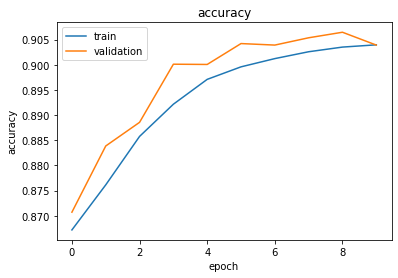

In [31]:
import matplotlib.pyplot as plt
plt.plot(model2.history['accuracy'])
plt.plot(model2.history['val_accuracy'])
plt.title("accuracy") 
plt.xlabel("epoch") 
plt.ylabel("accuracy") 
plt.legend(['train','validation']) 
plt.show()

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 

1. Download data from <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a>
2. Read the csv file
3. Remove all the html tags
4. Now do tokenization [Part 3 as mentioned above]
    * Create tokens,mask array and segment array
5. Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
   * Print the shape of output(X_test.shape).You should get (352,768)
6. Predit the output of X_test with the Neural network model which we trained earlier.
7. Print the occurences of class labels in the predicted output

</pre>

In [32]:
!gdown --id 1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo

Downloading...
From: https://drive.google.com/uc?id=1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo
To: /content/test.csv
100% 62.1k/62.1k [00:00<00:00, 54.2MB/s]


In [33]:
test_set = pd.read_csv(r"test.csv")
#check the info of the dataset
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    352 non-null    object
dtypes: object(1)
memory usage: 2.9+ KB


In [ ]:
test_set

,Text
0,Just opened Greenies Joint Care (individually ...
1,This product rocks :) My mom was very happy w/...
2,"The product was fine, but the cost of shipping..."
3,I love this soup. It's great as part of a meal...
4,Getting ready to order again. These are great ...
...,...
347,Without a doubt this is by far the BEST beef g...
348,My 8 month old loves these. He hardly swallows...
349,the flavor palet for this coffee is deep and r...
350,This is the best granola my family has ever ha...


In [34]:
tokenized_id_test_set = []
padded_list_test_set = []
segment_list_test_set = []
for review in tqdm((test_set['Text'])):
        tokens = tokenizer.tokenize(review)
        tokens = ['[CLS]', *tokens, '[SEP]']
        # ids = tokenizer.convert_tokens_to_ids(tokens)
        # ids = [ int(x) for x in ids ]
        # tokenized_id_test.append(ids)
        if len(tokens)<=max_seq_length: 
          #padding with [PAD]
            padded = tokens+['[PAD]' for i in range(max_seq_length - len(tokens))]
        ids = tokenizer.convert_tokens_to_ids(padded)
        ids = [ int(x) for x in ids ]
        padded_list_test_set.append(ids)
        segment = np.zeros(max_seq_length, dtype = int)
        segment_list_test_set.append(segment)

100%|██████████| 352/352 [00:00<00:00, 1416.39it/s]


In [35]:
attention_mask_test_set = np.where(np.array(padded_list_test_set) != [0], 1, 0)
X_test_tokens_set, X_test_mask_set, X_test_segment_set = np.array(padded_list_test_set),np.array(attention_mask_test_set),np.array(segment_list_test_set)

In [36]:
X_test_pooled_output_set = bert_model.predict([X_test_tokens_set,X_test_mask_set,X_test_segment_set])

In [38]:

prob = model.predict(X_test_pooled_output_set)
if prob.shape[-1] > 1:
   result = prob.argmax(axis=-1)
else:
  result = (prob > 0.5).astype('int32')

In [41]:
prediction = pd.DataFrame(data=prob,columns=['Prob_score'])
prediction['Result'] = result
prediction['Result'].value_counts()

1    328
0     24
Name: Result, dtype: int64

In [44]:
prediction['text'] = test_set['Text']
prediction

,Prob_score,Result,text
0,0.396946,0,Just opened Greenies Joint Care (individually ...
1,0.963675,1,This product rocks :) My mom was very happy w/...
2,0.768440,1,"The product was fine, but the cost of shipping..."
3,0.886539,1,I love this soup. It's great as part of a meal...
4,0.886539,1,Getting ready to order again. These are great ...
...,...,...,...
347,0.658051,1,Without a doubt this is by far the BEST beef g...
348,0.973695,1,My 8 month old loves these. He hardly swallows...
349,0.943045,1,the flavor palet for this coffee is deep and r...
350,0.943045,1,This is the best granola my family has ever ha...


Here we are using  BERT base having 12 Encode bloacks  with 12 attention heads, and 110 million parameters

Data preprocessing : 
We had done  Preprocessing of the text to remove HTML tags and converted the text into lowercase.

Train test split and using pretrained BERT model to get embeddings:
Split the data as train and test, startify as yes to maintain equal split among Target label. 

Inorder to use BERT model we need  to give 
  
   Input of word as token
  
   Masking 
  
   Segement  
When we give these inputs we are getting
pooled_output -  representation of [batch_size, 768]  
and sequence_output [batch_size, max_seq_length, 768]  

For classification we are using NN with RELU activation. 